In [6]:
# Enable inline Matplotlib
%matplotlib inline

# Imports
# JSON
import json

# NumPy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Pandas
import pandas as pd

In [2]:
def data_loader(file_path, target_beacons, distance):
    with open(file_path) as json_file:
        data = json.load(json_file)
        data['target_beacons'] = target_beacons
        data['distance'] = distance   
        return data

In [3]:
# Load Data
data = []
target_beacons = [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 101 }]
data.append(data_loader('data/beacons/fake-log-1-100-0.5m.json', target_beacons, 0.5))
data.append(data_loader('data/beacons/fake-log-1-100-1m.json', target_beacons, 1))
data.append(data_loader('data/beacons/fake-log-1-100-2m.json', target_beacons, 2))

In [34]:
table = []

for log in data:
    #print('Log', log['name'], 'which started at:', log['creationTimestamp'])
    #print('Focusing on:')
    for beacon in log['target_beacons']:
        #print('UUID:', beacon['uuid'], 'Major:', beacon['major'], 'Minor:', beacon['minor'])
        for entries in log['sessions'].values():
            for entry in entries:
                #print(entry)
                reading = entry['reading']
                if reading['type'] == 'iBeacon' and reading['values'][0] == beacon['uuid']\
                and reading['values'][1] == beacon['major'] and reading['values'][2] == beacon['minor']:
                    #print(reading)
                    table.append([log['name'],
                                  pd.to_datetime(log['creationTimestamp'], unit='ms'),
                                  entry['id'],
                                  reading['id'],
                                  reading['type'],
                                  str(reading['values']),
                                  reading['values'][0],
                                  reading['values'][1],
                                  reading['values'][2],
                                  reading['txPower'],
                                  reading['rssi'],
                                  pd.to_datetime(reading['timestamp'], unit='ms'),
                                  reading['avgRssi'], 
                                  log['distance']])
                    
df = pd.DataFrame(table, columns=['filename',
                               'creationTimestamp',
                               'entry',
                               'id',
                               'type',
                               'values',
                               'uuid',
                               'major',
                               'minor',
                               'txPower',
                               'rssi',
                               'timestamp',
                               'avgRssi', 
                               'distance'])
df.set_index('timestamp', inplace=True, verify_integrity=True)
df['rollingMeanRssi'] = df.rssi.rolling('5s').mean()
df

,filename,creationTimestamp,entry,id,type,values,uuid,major,minor,txPower,rssi,avgRssi,distance,rollingMeanRssi
timestamp,,,,,,,,,,,,,,
2019-10-01 13:40:44.754,fake-log-1-100-0.5m.json,2019-10-01 13:40:43.279,0,4969cb0f7064,iBeacon,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",113069EC-6E64-4BD3-6810-DE01B36E8A3E,1,101,-59,-46,-45.181818,0.5,-46.000000
2019-10-01 13:40:46.256,fake-log-1-100-0.5m.json,2019-10-01 13:40:43.279,1,4969cb0f7064,iBeacon,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",113069EC-6E64-4BD3-6810-DE01B36E8A3E,1,101,-59,-46,-45.400000,0.5,-46.000000
2019-10-01 13:40:47.614,fake-log-1-100-0.5m.json,2019-10-01 13:40:43.279,2,4969cb0f7064,iBeacon,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",113069EC-6E64-4BD3-6810-DE01B36E8A3E,1,101,-59,-46,-45.428571,0.5,-46.000000
2019-10-01 13:40:49.250,fake-log-1-100-0.5m.json,2019-10-01 13:40:43.279,3,4969cb0f7064,iBeacon,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",113069EC-6E64-4BD3-6810-DE01B36E8A3E,1,101,-59,-46,-45.656250,0.5,-46.000000
2019-10-01 13:40:50.746,fake-log-1-100-0.5m.json,2019-10-01 13:40:43.279,4,4969cb0f7064,iBeacon,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",113069EC-6E64-4BD3-6810-DE01B36E8A3E,1,101,-59,-43,-45.545455,0.5,-45.250000
2019-10-01 13:40:52.108,fake-log-1-100-0.5m.json,2019-10-01 13:40:43.279,5,4969cb0f7064,iBeacon,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",113069EC-6E64-4BD3-6810-DE01B36E8A3E,1,101,-59,-49,-45.424242,0.5,-46.000000
2019-10-01 13:40:53.743,fake-log-1-100-0.5m.json,2019-10-01 13:40:43.279,6,4969cb0f7064,iBeacon,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",113069EC-6E64-4BD3-6810-DE01B36E8A3E,1,101,-59,-42,-45.093750,0.5,-45.000000
2019-10-01 13:41:24.396,fake-log-1-100-1m.json,2019-10-01 13:41:22.973,0,4969cb0f7064,iBeacon,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",113069EC-6E64-4BD3-6810-DE01B36E8A3E,1,101,-59,-84,-67.800000,1.0,-84.000000
2019-10-01 13:41:25.887,fake-log-1-100-1m.json,2019-10-01 13:41:22.973,1,4969cb0f7064,iBeacon,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",113069EC-6E64-4BD3-6810-DE01B36E8A3E,1,101,-59,-57,-65.833333,1.0,-70.500000


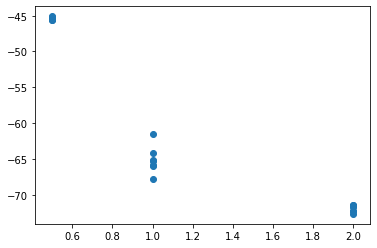

In [36]:
plt.scatter(df.distance, df.avgRssi)